## USEFUL PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import emoji
import re
from itertools import cycle
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
# Para tratamientos de texto
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import spacy
import es_core_news_md
from spellchecker import SpellChecker

# Modelos Scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,HistGradientBoostingClassifier,GradientBoostingClassifier,StackingClassifier

# Evaluacion
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,balanced_accuracy_score,precision_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay



#---------------------------------------------------------------------------------#
warnings.filterwarnings('ignore')

In [2]:
def read_dataset(path):
    tree = ET.parse(path)
    root = tree.getroot()
    value = []
    for sentiment in root.iter('sentiment'):
        for polarity in sentiment.iter('polarity'):
            for deep_tag in polarity:
            #print(deep_tag.text)
                value.append(deep_tag.text)
    df = pd.read_xml(path)
    df['sentiment'] = value
    return df

## Corpus 2018

In [3]:
df_train_2018 = pd.DataFrame()
for filename in os.listdir('../data2018/train/'):
    df_initial_2018 = read_dataset('../data2018/train/'+filename)
    df_train_2018 = pd.concat([df_train_2018,df_initial_2018])
df_train_2018 = df_train_2018[['tweetid', 'content', 'sentiment']]
df_train_2018.columns = ['id', 'tweet', 'classification']

## CORPUS 2019

In [4]:
df_train_2019 = pd.DataFrame()
for filename in os.listdir('../data2019/train/'):
    df_initial_2019 = read_dataset('../data2019/train/'+filename)
    df_train_2019 = pd.concat([df_train_2019,df_initial_2019])
df_train_2019 = df_train_2019[['tweetid', 'content', 'sentiment']]
df_train_2019.columns = ['id', 'tweet', 'classification']

## DATASET 2020

In [5]:
df_initial_1 = pd.DataFrame()
for filename in os.listdir('../data/train/'):
    df_country = pd.read_csv('../data/train/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'train'
    df_initial_1 = pd.concat([df_initial_1, df_country])
df_initial_2 = pd.DataFrame()
for filename in os.listdir('../data/dev/'):
    df_country = pd.read_csv('../data/dev/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'dev'
    df_initial_2 = pd.concat([df_initial_2, df_country])

df_initial = pd.concat([df_initial_1,df_initial_2])
df_initial = df_initial.drop_duplicates(subset='id')
df_initial = df_initial.replace({'classification':{'N':0,'NEU':1,'P':2}})
df_initial.head(1)

,id,tweet,classification
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,0


In [6]:
df_final_test = pd.DataFrame()
for filename in os.listdir('../data/test/'):
    df_country_test = pd.read_csv('../data/test/'+ filename, sep='\t', names=['id','tweet'])
    #df_country_test['fuente'] = filename+'test'
    df_final_test = pd.concat([df_final_test, df_country_test])

df_final_sentiment = pd.DataFrame()
for filename in os.listdir('../data/testgold/'):
    df_country_testgold = pd.read_csv('../data/testgold/'+ filename, sep='\t', names=['id','classification'])
    #df_country_testgold['fuente'] = filename+'test'
    df_final_sentiment = pd.concat([df_final_sentiment, df_country_testgold])

df_final = df_final_test.merge(df_final_sentiment, how = 'left', on = 'id')   
df_final = df_final.replace({'classification':{'N':0,'NEU':1,'P':2}})
df_final = df_final.drop_duplicates(subset='id')


In [7]:
df_final.groupby('classification').count()

,id,tweet
classification,,
0,2939,2939
1,1966,1966
2,2359,2359


In [8]:
df_final.shape

(7264, 3)

In [9]:
df_initial.groupby('classification').count()

,id,tweet
classification,,
0,2835,2835
1,2315,2315
2,2093,2093


0    2835
1    2315
2    2093
Name: classification, dtype: int64
Tamaño del dataset: (7243, 3)


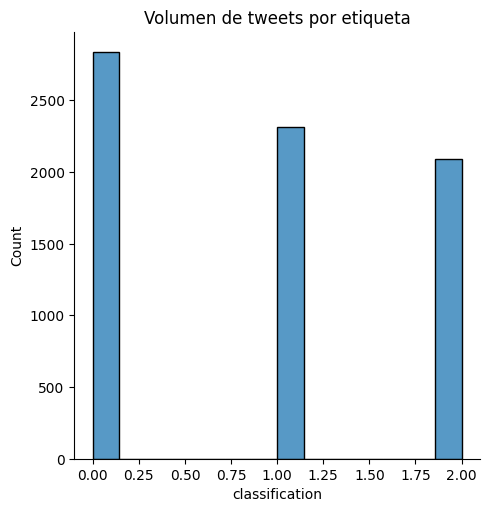

In [10]:
# Comprobamos distribución de la etiqueta 'classification'
sns.displot(df_initial.classification)
plt.title('Volumen de tweets por etiqueta');
print(df_initial.classification.value_counts())
print('Tamaño del dataset:', df_initial.shape)

(0.0, 40.0)

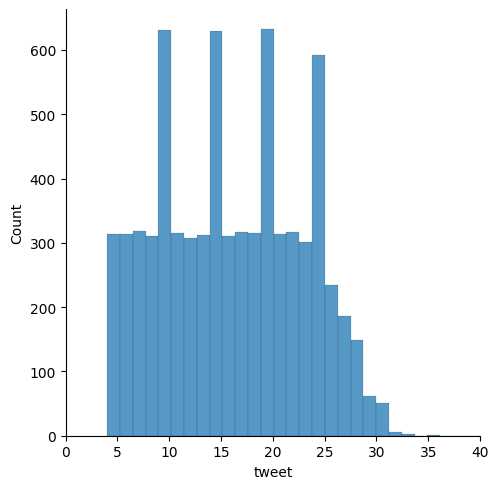

In [11]:
def count_words(df):
    count = 0
    for word in df.split():
        count += 1
    return count
#------------------------------------------------------------------------------------#
## recortar el eje x hasta 100 para mejorar la visualizacion.
ax = sns.displot(df_initial['tweet'].apply(count_words))
plt.xlim(0,40)

### Funciones para tratamiento de datos


* Debemos tener que estos tweets no están normalizados y por lo tanto debemos diseñar funciones que no permitan normalizar las expreciones escritas, quitar, emojis y corregir algunas otras cosas para no tener palabras que aunque signifiquen lo mismo parezcan diferentes.

In [12]:
# Eliminamos signos de puntuación y sustituimos por espacios en blanco

def remove_punctuation_space(df):
    PUNCTUATION = re.compile("""(\-)|(\,)|(\..)|(\...)|(\....)|(\.....)|(\......)|(\.......)""")
    
    return " ".join([PUNCTUATION.sub(" ", word.lower()) for word in df.split()])

In [13]:
# Eliminamos signos de puntuación sin reemplazo

def remove_punctuation(df):
    PUNCTUATION = re.compile("""(\.)|(\;)|(\:)|(\!)|(\?)|(\¡)|(\¿)| \
    (\")|(\()|(\))|(\[)|(\])|(\d+)|(\/)|(\“)|(\”)|(\')|(\-)|(\")|(\*)""")
    
    return " ".join([PUNCTUATION.sub("", word.lower()) for word in df.split()])

In [14]:
# Corregimos abreviaciones
def fix_abbr(x):
    if type(x) == list:
        words = x
    elif type(x) == str:
        words = x.split()
    else:
        raise TypeError('El formato no es válido, debe ser lista o str')

    abbrevs = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
    return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in words])

In [15]:

# Sustituimos links por {link}
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

In [16]:
# Eliminamos vocales repetidas
    
def remove_repeated_vocals(df):
    
    list_new_word = []

    for word in df.split(): #separamos en palabras
        new_word = []
        pos = 0
        
        for letra in word: #separamos cada palabra en letras
            #print(word, letra, pos, '-', new_word)
            if pos>0:
                if letra in ('a', 'e', 'i', 'o', 'u') and letra == new_word[pos-1]:
                    None
                else:
                    new_word.append(letra)
                    pos +=1
            else:
                new_word.append(letra)
            
                pos += 1
        else:
            list_new_word.append("".join(new_word))
                
    return " ".join(list_new_word)

In [17]:
# Normalizamos risas 'jajaja', 'jejeje', 'jojojo'
    
def normalize_laughts(df):
    
    list_new_words = []
    for word in df.split(): #separamos en palabras
        count = 0
        vocals_dicc = {'a': 0, 'e': 0, 'i': 0, 'o':0, 'u':0}
        
        for letra in word:
            #print(word)
            if letra == 'j':
                count+=1
            if letra in vocals_dicc.keys():
                vocals_dicc[letra] += 1
        else:
            if count>3:
                dicc_risa = {'a': 'jaja', 'e': 'jeje', 'i': 'jiji', 'o': 'jojo', 'u': 'juju'}
                risa_type = max(vocals_dicc, key= lambda x: vocals_dicc[x]) #Indica si es a,e,i,o,u
                list_new_words.append(dicc_risa[risa_type])
            else:
                list_new_words.append(word)
    
    return " ".join(list_new_words)

In [18]:
# Sustituimos hashtag por {hash}
def remove_hashtags(df):
    return " ".join(['{hash}' if word.startswith('#') else word for word in df.split()])

In [19]:
# Sustituimos menciones por {mencion}
def remove_mentions(df):
    return " ".join(['{menc}' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

In [20]:
# Función para identificar los 'emojis' tradicionales

def transform_icons(df):
    word_list = []
    pos_emojis = [':)', ':D', ':))', ':)))', 'xD', 'xd', 'XD']
    neg_emojis = [':(', ":'(", '>:(', ':,(', ":(("]
    for word in df.split():
        if word in neg_emojis:
            word = '{emoji_neg}'
            word_list.append(word)
        elif word in pos_emojis:
            word = '{emoji_pos}'
            word_list.append(word)
        elif ':O' in word:
            word = '{emoji_neu}'
            word_list.append(word)
        else:
            word_list.append(word)
    return " ".join(word_list)

In [21]:
# Separamos emojis que vengan juntos
def sep_emojis(df):
    words_list = []
    for token in df.split():
        new_word = []
        for letra in token:
            if letra in emoji.UNICODE_EMOJI['es']:
                words_list.append(letra)
            else:
                new_word.append(letra)
        else:
            words_list.append("".join(new_word))

    return (" ".join(word for word in words_list if word != ''))

In [22]:
# Eliminamos stopwords
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
non_stopwords = ['no', 'ni', 'poco', 'mucho', 'nada', 'muchos', 'muy', 'nosotros',
                 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ella', 'él', 'tu', 'tú', 'yo',
                 'pero', 'hasta', 'contra', 'por']
spanish_stopwords = [word for word in stopwords.words('spanish') if word not in non_stopwords]

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Función para stemizar
def stem(df):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in df.split()])

In [24]:
# Función para lematizar
# Creamos el objeto
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load("es_core_news_md")


# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        elif str(tok) == 'eur':
              word_list.append('{eur}')
        else:
            word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')])  

In [25]:
# Función para corregir las palabras

spell = SpellChecker(language='es', distance=1)

def correcting_words(df):
    misspelled = spell.unknown(df.split())
    return " ".join(filter(None,[spell.correction(word) if word in misspelled else word for word in df.split()]))

In [26]:
def remove_eur(df):
    wlist = ['{eur}' if ('€' in word) | ('euro' in word) | ('$' in word) else word for word in df.split()]
    return " ".join(wlist)

In [27]:
# Put it all together

def transform_tweets(df, mode='lemma'):
    
    df = remove_links(df)
    df = remove_punctuation_space(df)
    df = remove_mentions(df)    
    df = remove_hashtags(df)
    df = remove_eur(df)
    df = transform_icons(df)
    df = sep_emojis(df)
   # df = transform_emoji(df)
    df = normalize_laughts(df)
    df = remove_punctuation(df)
    df = remove_repeated_vocals(df)
    df = correcting_words(df)
    df = fix_abbr(df)
    df = remove_stopwords(df)
    if mode=='lemma':
        df = lemmatizer(df)
    elif mode=='stem':
        df = stem(df)
    else:
        raise TypeError('Invalid mode. Must be "lemma" or "stem"') 
    df = remove_stopwords(df)                    
    return df

El stemizado es mejor para usar en ingles, es mejor el lemetizado para lenguas romance

In [46]:
text = 'hola te amo santi hermoso de mi corazon'

In [47]:
text_p = transform_tweets(text, mode='lemma')

In [48]:
text_p

'hola amo santi hermoso corazon'

In [28]:
print('Tweet original:\n', df_initial.tweet[50:51].iloc[0])
print('Tweet lematizado:\n', df_initial.tweet[50:51].apply(transform_tweets, mode='lemma').iloc[0])
print('Tweet stemizado:\n',df_initial.tweet[50:51].apply(transform_tweets, mode='stem').iloc[0])

Tweet original:
 Nos encanta hacerte feliz @rubndu
Tweet lematizado:
 encantar hacer tú feliz
Tweet stemizado:
 encant hacert feliz


In [29]:
%%time
# Aplicamos
df_initial['tweet_'] = df_initial.tweet.apply(transform_tweets, mode='lemma')
df_final['tweet_'] = df_final.tweet.apply(transform_tweets, mode='lemma')

CPU times: total: 45.4 s
Wall time: 48.6 s


# Modelos 

In [30]:
df_all = pd.concat([df_initial,df_final])

In [31]:
df_all.to_csv('df_all.csv')

In [40]:
df_all.head()

,id,tweet,classification,tweet_
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,0,definitivo quedar campo ir mentalizado hasta q...
1,796040775364710400,@dianalaa32 Es una escena de uno de los docume...,2,escena documental respetado naturaleza planet ...
2,802912779854352384,Qué feo es tener que terminar con alguien; y m...,0,feo tener terminar alguien dos persona aún ama...
3,800835505717972992,"Oído en McDonalds ""el mejor mannequin challeng...",0,oer mcdonalds mejor challenge visto hasta ahor...
4,791640101751230464,Tengo que aceptar que me esta hundiendo el con...,1,aceptar hundir consumismo nuevo pro gorro hero...


In [32]:
X = df_all[['tweet_']]

In [33]:
from transformers import RobertaTokenizer, RobertaModel
import torch.nn as nn

import torch

In [34]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
torch.save(tokenizer,'tokenizador.pt')
torch.save(model,'modelo_t.pt')

In [36]:
tokenizador = torch.load('tokenizador.pt')
modelo_t = torch.load('modelo_t.pt')

In [37]:
def embed_text(text):
    # Tokeniza el texto
    input_ids = torch.tensor([tokenizador.encode(text, add_special_tokens=True,max_length=250,truncation=True)])
    # Genera los embeddings
    with torch.no_grad():
        output = modelo_t(input_ids)
        embeddings = output[0][:, 0, :].numpy()
    return embeddings

In [38]:
X['embedding'] = X.tweet_.apply(embed_text) 

In [39]:
X

,tweet_,embedding
0,definitivo quedar campo ir mentalizado hasta q...,"[[-0.03869699, 0.056530945, 0.014290894, -0.09..."
1,escena documental respetado naturaleza planet ...,"[[-0.033285134, 0.036981627, 0.042415507, -0.1..."
2,feo tener terminar alguien dos persona aún ama...,"[[-0.044214092, 0.06212446, 0.017362, -0.11375..."
3,oer mcdonalds mejor challenge visto hasta ahor...,"[[-0.057279296, 0.051750254, 0.031811405, -0.0..."
4,aceptar hundir consumismo nuevo pro gorro hero...,"[[-0.037349813, 0.06989633, 0.008028469, -0.06..."
...,...,...
7259,bueno no modesto periodista calificar,"[[-0.03622829, 0.0675046, 0.0111574745, -0.104..."
7260,tu medio manzana + comio,"[[-0.055846073, 0.053929858, -0.0015685465, -0..."
7261,hablar por aca yo tambien extraño,"[[-0.054296635, 0.056503676, -0.001965506, -0...."
7262,encantar muchacho pero previo aburrar,"[[-0.04686512, 0.07875471, 0.0058485344, -0.11..."


In [37]:
embedding_matrix = np.vstack(X['embedding'])

# Crea un nuevo dataframe con una columna separada para cada valor del embedding
new_df = pd.DataFrame(embedding_matrix, columns=['embedding_{}'.format(i) for i in range(embedding_matrix.shape[1])])


In [38]:
embedding_matrix.shape

(14507, 768)

In [39]:
new_df.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.038697,0.056531,0.014291,-0.090218,0.044688,-0.096564,-0.031730,0.003258,0.095233,-0.087979,...,-0.002202,0.002461,-0.076560,-0.107523,-0.000543,0.112858,0.059542,-0.040384,-0.026678,-0.046287
1,-0.033285,0.036982,0.042416,-0.101813,0.044333,-0.100968,-0.065766,0.014792,0.049005,-0.094288,...,0.030529,-0.007058,-0.068319,-0.139354,-0.054758,0.126866,0.074703,-0.120616,-0.025233,-0.011219
2,-0.044214,0.062124,0.017362,-0.113754,0.043926,-0.098733,-0.070465,0.004263,0.065432,-0.090390,...,-0.009436,-0.013152,-0.068776,-0.110305,-0.043520,0.110979,0.073648,-0.063428,-0.045474,-0.038345
3,-0.057279,0.051750,0.031811,-0.096803,0.046696,-0.093878,-0.061002,-0.013117,0.078209,-0.096927,...,-0.007264,-0.009776,-0.077911,-0.120516,-0.057491,0.097555,0.077052,-0.095396,-0.055069,-0.053286
4,-0.037350,0.069896,0.008028,-0.067640,0.027968,-0.117158,-0.041774,-0.014320,0.077868,-0.080117,...,0.024209,-0.008687,-0.086265,-0.102610,0.006147,0.114367,0.091128,-0.098419,-0.048066,0.018384


# Exportando el archivo

In [40]:
new_df.to_csv('Embedding.csv', index = False)

# Aquí van las reducciones de dimensionalidad 

In [41]:
df_nuevo = pd.read_csv('Embedding.csv')
df_nuevo.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.038697,0.056531,0.014291,-0.090218,0.044688,-0.096564,-0.031730,0.003258,0.095233,-0.087979,...,-0.002202,0.002461,-0.076560,-0.107523,-0.000543,0.112858,0.059542,-0.040384,-0.026678,-0.046287
1,-0.033285,0.036982,0.042416,-0.101813,0.044333,-0.100968,-0.065766,0.014792,0.049005,-0.094288,...,0.030529,-0.007058,-0.068319,-0.139354,-0.054758,0.126866,0.074703,-0.120616,-0.025233,-0.011219
2,-0.044214,0.062124,0.017362,-0.113754,0.043926,-0.098733,-0.070465,0.004263,0.065432,-0.090390,...,-0.009436,-0.013152,-0.068776,-0.110305,-0.043520,0.110979,0.073648,-0.063428,-0.045474,-0.038345
3,-0.057279,0.051750,0.031811,-0.096803,0.046696,-0.093878,-0.061002,-0.013117,0.078209,-0.096927,...,-0.007264,-0.009776,-0.077911,-0.120516,-0.057491,0.097555,0.077052,-0.095396,-0.055069,-0.053286
4,-0.037350,0.069896,0.008028,-0.067640,0.027968,-0.117158,-0.041774,-0.014320,0.077868,-0.080117,...,0.024209,-0.008687,-0.086265,-0.102610,0.006147,0.114367,0.091128,-0.098419,-0.048066,0.018384
